In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from pathlib import Path
import os

In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
MASTER_PATH =  '/content/drive/My Drive/AirInvestor/'

DATA_PATH = MASTER_PATH + 'Airbnb_data/'

OUTPUT_PATH = MASTER_PATH + 'outputs/'

CACHE_PATH = MASTER_PATH + 'cache_dir/'

In [4]:
# read and concatenate the data

df_2020 = pd.read_csv(DATA_PATH + 'listings_March2020.csv')
df_2019 = pd.read_csv(DATA_PATH + 'listings_March2019.csv')
df_2018 = pd.read_csv(DATA_PATH + 'listings_April2018.csv')

frames = [df_2020,df_2019,df_2018]
df_list = pd.concat(frames)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data preprocessing

In [5]:
df = df_list[['id', 'description', 'price']].dropna()

#remove duplicates, only keep the first instance

df = df.drop_duplicates(['id'])

# remove "$" from price and convert price to integer
df['price'] = df['price'].str.slice(1,-3).str.replace(",","")
df['price'] = df['price'].astype(int)

#remove the data with price lower than $10
df = df[df['price'] > 10]

# get rid of the data that have sentence length smaller than 5 words
df['length'] = df['description'].str.split().str.len()
df = df[df['length']>=5]

print("number of rows {}, number of unique ids {}, number of unique length {}".format(df.shape[0], len(set(df['id'])), len(set(df['length']))))

df.head()

number of rows 19381, number of unique ids 19381, number of unique length 206


,id,description,price,length
0,2265,Zen East is situated in a vibrant & diverse mu...,225,168
1,5245,Situated in a vibrant & diverse multicultural ...,100,166
2,5456,Great central location for walking to Convent...,95,155
3,5769,Looking for a comfortable inexpensive room to ...,40,182
4,6413,"Great studio apartment, perfect for couples or...",99,166


maximum sentence length is 213
median sentence length is 165.0
minimum sentence length is 5
count    19381.000000
mean       138.688819
std         51.686682
min          5.000000
25%        104.000000
50%        165.000000
75%        175.000000
90%        182.000000
95%        186.000000
max        213.000000
Name: length, dtype: float64


Text(0, 0.5, 'number of samples')

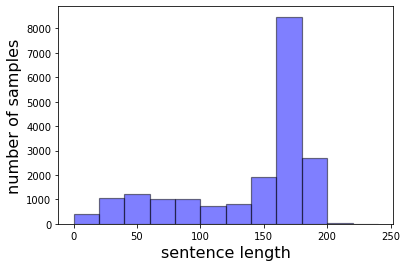

In [15]:
# Describe and visulize the distribution of the sentence length

print(df['length'].describe([0.25,0.5,0.75,0.9,0.95]))

bin_values = np.arange(start=0, stop=250, step=20)

n, bins, patches = plt.hist(df['length'], bin_values, facecolor='blue', alpha=0.5, edgecolor='black', linewidth=1.2)

plt.xlabel("sentence length", fontsize=16)
plt.ylabel('number of samples', fontsize=16)


count    19381.000000
mean       399.262628
std       1193.930335
min         12.000000
25%         80.000000
50%        145.000000
75%        300.000000
90%        650.000000
95%       1000.000000
max      10900.000000
Name: price, dtype: float64


Text(0, 0.5, 'number of samples')

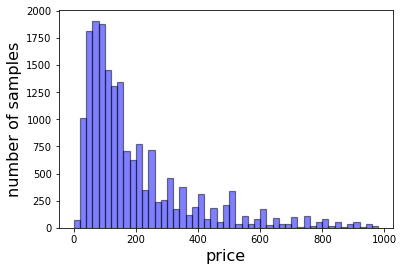

In [16]:
# Describe and visulize the distribution of price

print(df['price'].describe([0.25,0.5,0.75,0.9,0.95]))

bin_values = np.arange(start=0, stop=1000, step=20)

n, bins, patches = plt.hist(df['price'], bin_values, facecolor='blue', alpha=0.5, edgecolor='black', linewidth=1.2)

plt.xlabel('price', fontsize=16)
plt.ylabel('number of samples', fontsize=16)

In [0]:
cla_price, bins= pd.qcut(df['price'], 7, retbins=True, precision = 0, labels=False)
print(bins)
df['cla_price'] = cla_price
print(df.head(10))

[   12.    58.    88.   120.   170.   250.   499. 10900.]
      id                                        description  ...  length  cla_price
0   2265  Zen East is situated in a vibrant & diverse mu...  ...     168          4
1   5245  Situated in a vibrant & diverse multicultural ...  ...     166          2
2   5456  Great central  location for walking to Convent...  ...     155          2
3   5769  Looking for a comfortable inexpensive room to ...  ...     182          0
4   6413  Great studio apartment, perfect for couples or...  ...     166          2
5   6448  Our garage apartment provides a private space ...  ...     164          3
6   8502  Fully furnished suite with kitchen, bathroom, ...  ...     152          0
7  14913  This property is a 3 bdr 2 bath in south Austi...  ...     184          5
8  21126  Indulge in BBQ on the spacious patio, or enjoy...  ...      43          6
9  21145  Quaint guest house is pet friendly with a priv...  ...     169          4

[10 rows x 5 colu

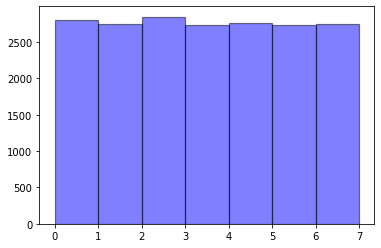

In [0]:
# visulize the distribution of price after classification
bin_values = np.arange(start=0, stop=8, step=1)

n, bins, patches = plt.hist(df['cla_price'], bin_values, facecolor='blue', alpha=0.5, edgecolor='black', linewidth=1.2)

In [0]:
# buid classification dataset 
df_cla = df[['id','description', 'cla_price']]
df_cla.head()

,id,description,cla_price
0,2265,Zen East is situated in a vibrant & diverse mu...,4
1,5245,Situated in a vibrant & diverse multicultural ...,2
2,5456,Great central location for walking to Convent...,2
3,5769,Looking for a comfortable inexpensive room to ...,0
4,6413,"Great studio apartment, perfect for couples or...",2


In [0]:
# Split dataframe to train, dev dataset
df_train, df_dev = train_test_split(df_cla, test_size = 0.1, random_state=1)
print(df_train.shape, df_dev.shape)

(17442, 3) (1939, 3)


In [0]:
#store the train and dev data to files
df_train.to_csv(MASTER_PATH + 'data_cla/train.csv', index=False, header = True)
df_dev.to_csv(MASTER_PATH + 'data_cla/dev.csv', index=False, header = True)

## Language Deteiction

In [0]:
#read out the stored files
df_train = pd.read_csv (MASTER_PATH + 'data_cla/train.csv')
df_dev = pd.read_csv (MASTER_PATH + 'data_cla/dev.csv')

df = pd.concat([df_train,df_dev])

df.head()

,id,description,cla_price
0,21717072,Welcome to our Texas Hill Country Luxury Home ...,6
1,26536675,Modern home in vibrant East Austin neighborhoo...,5
2,12136858,"Comfortable bedroom available in gorgeous, fam...",1
3,17256962,"We just renovated the unit, hired a local inte...",2
4,18617668,More flexible than ever in 2020 due to increas...,4


In [0]:
# detect language
%pip install langdetect

     |████████████████████████████████| 983kB 6.5MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993193 sha256=c57926049cd96cce64aaf486a34baebb4727b2d7521136c85941a64b7eeefc34
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


In [0]:
# we use Python's langdetect 
from langdetect import detect

# write the function that detects the language
def language_detection(text):
    try:
        return detect(text)
    except:
        return None

In [0]:
%%time
df['language'] = df['description'].apply(language_detection)

CPU times: user 1min 37s, sys: 780 ms, total: 1min 38s
Wall time: 1min 38s


In [0]:
df.language.value_counts().head(10)

en    19369
es        4
fr        2
af        2
nl        1
pt        1
de        1
ca        1
Name: language, dtype: int64

In [0]:
print(f"number of total text description {df.shape[0]}, of which {(df.language== 'en').sum()} is English")

number of total text description 19381, of which 19369 is English


###### Rhe majority text is written in English, so we won't bother about clear the language

### Buid regression dataset 

In [6]:
df_reg = df[['id','description', 'price']]
df_reg.head()

,id,description,price
0,2265,Zen East is situated in a vibrant & diverse mu...,225
1,5245,Situated in a vibrant & diverse multicultural ...,100
2,5456,Great central location for walking to Convent...,95
3,5769,Looking for a comfortable inexpensive room to ...,40
4,6413,"Great studio apartment, perfect for couples or...",99


count    17429.000000
mean       172.122440
std        135.543576
min         12.000000
25%         75.000000
50%        125.000000
75%        225.000000
90%        395.000000
95%        499.000000
max        649.000000
Name: price, dtype: float64


Text(0, 0.5, 'number of samples')

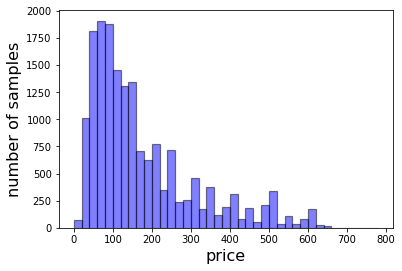

In [8]:
df_reg= df_reg[df_reg['price']<650]
print(df_reg['price'].describe([0.25,0.5,0.75,0.9,0.95]))
bin_values = np.arange(start=0, stop=800, step=20)

n, bins, patches = plt.hist(df_reg['price'], bin_values, facecolor='blue', alpha=0.5, edgecolor='black', linewidth=1.2)
plt.xlabel('price', fontsize=16)
plt.ylabel('number of samples', fontsize=16)

649 12
count    17429.000000
mean         0.251370
std          0.212784
min          0.000000
25%          0.098901
50%          0.177394
75%          0.334380
90%          0.601256
95%          0.764521
max          1.000000
Name: norm_price, dtype: float64


Text(0, 0.5, 'number of samples')

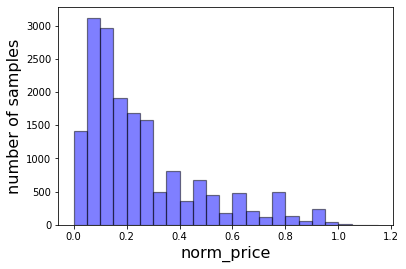

In [9]:
max_price = np.max(df_reg['price'])
min_price = np.min(df_reg['price'])
print(max_price, min_price)
df_reg['norm_price'] = df_reg['price'].apply(lambda x: (x-min_price)/(max_price-min_price))
print(df_reg['norm_price'].describe([0.25,0.5,0.75,0.9,0.95]))

bin_values = np.arange(start=0, stop=1.2, step=0.05)

n, bins, patches = plt.hist(df_reg['norm_price'], bin_values, facecolor='blue', alpha=0.5, edgecolor='black', linewidth=1.2)
plt.xlabel('norm_price', fontsize=16)
plt.ylabel('number of samples', fontsize=16)


In [10]:
df_reg.head()

,id,description,price,norm_price
0,2265,Zen East is situated in a vibrant & diverse mu...,225,0.334380
1,5245,Situated in a vibrant & diverse multicultural ...,100,0.138148
2,5456,Great central location for walking to Convent...,95,0.130298
3,5769,Looking for a comfortable inexpensive room to ...,40,0.043956
4,6413,"Great studio apartment, perfect for couples or...",99,0.136578


In [11]:
df_price = df_reg[['id', 'description','price']]
df_norm = df_reg[['id', 'description','norm_price']]

# Split dataframe to train and dev dataset
df_train, df_dev = train_test_split(df_norm, test_size = 0.1, random_state=1)
print(df_train.shape, df_dev.shape)

(15686, 3) (1743, 3)


In [12]:
df_train.to_csv(MASTER_PATH + 'data_reg/train.csv', index=False, header = True)
df_dev.to_csv(MASTER_PATH + 'data_reg/dev.csv', index=False, header = True)
df_train.head()

,id,description,norm_price
2162,8684602,SXSW/ACL ready! Downtown location on Barton Sp...,0.169545
8447,34506853,We LOVE our home and our location! Our woodsy...,0.813187
10152,23239928,This apartment is located in the South Congres...,0.136578
4288,13954933,Newly renovated apartment style condo just 3 m...,0.138148
3672,17009835,"My place is close to downtown, the capital bui...",0.295133


## Read train and test data out 

In [7]:
df_train = pd.read_csv(MASTER_PATH + 'data_reg/train.csv')
df_dev = pd.read_csv(MASTER_PATH + 'data_reg/dev.csv')
df = pd.concat([df_train, df_dev])

,id,description,price
0,10694691,"One bedroom+bath w/ private entrance, dedicate...",129
1,23626750,Outdoor entertaining area includes: Two bars...,400
2,2386534,Our lovely 2 bedroom cottage is a perfect plac...,150
3,1109489,This renovated mid-century - located approxima...,65
4,9028362,Quaint and cozy with complete privacy. It's a ...,90


In [9]:
df.describe()

,id,price
count,1.040500e+04,10405.000000
mean,2.351623e+07,496.400673
std,1.311821e+07,1521.424533
min,5.245000e+03,14.000000
25%,1.229124e+07,81.000000
50%,2.354207e+07,149.000000
75%,3.570431e+07,300.000000
max,4.292974e+07,10000.000000


## Use simple transformer to predict the label

In [0]:
# Create a ClassificationModel
model = ClassificationModel('bert', 'bert-base-uncased', num_labels=7, weight = True, args={'max_seq_length':300, "num_train_epochs":4, "output_dir":OUTPUT_PATH, "cache_dir":CACHE_PATH, "overwrite_output_dir": False, "fp16":False}, use_cuda= True)

TypeError: ignored

In [0]:
# Train the model
#df_train_small = df_train.iloc[:10,:]
model.train_model(df_train)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:249: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 1.876340

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 1.261957


Running loss: 2.396119


Running loss: 1.028071


Running loss: 0.262123



In [0]:
#evaluate model

# Load a trained model that you have fine-tuned

# output_model_file = MASTER_PATH + 'outputs_4Epoch/pytorch_model.bin'
# model_state_dict = torch.load(output_model_file)

model = ClassificationModel()
#model = BertForMultiLabelSequenceClassification.from_pretrained(args['bert_model'], num_labels = 7, state_dict=model_state_dict)

SyntaxError: ignored

In [0]:
#evaluation on trained dataset
#df_eval_small = df_eval.iloc[1:11,:]
result, model_outputs, wrong_predictions = model.eval_model(df_train, acc=accuracy_score)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:587: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


In [0]:
print(result)

{'mcc': 0.7652764637390458, 'acc': 0.8093479739578272, 'eval_loss': 0.5697695512466405}


In [0]:
result_eval, model_outputs_eval, wrong_predictions_eval = model.eval_model(df_eval, acc=accuracy_score)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:587: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


In [0]:
print(result_eval)

{'mcc': -0.0019421016233785676, 'acc': 0.13024475524475523, 'eval_loss': 1.9298091901765837}


In [0]:
# make prediction
predictions, raw_outputs = model.predict(train_df['description'].tolist())

In [0]:
%ls


drive/  sample_data/


In [0]:
print(predictions)

[2 6 2 6 4 4 2]


In [0]:
train_df.head(100)

,description,cla_price
8650,Situated in East Austin at the intersection of...,2
11331,Grand Opening - Complimentary breakfast and WI...,6
10650,"8 guest, 2 private bedrooms, two sofa bed in m...",2
2038,Two bedroom apartment in a complex with a gorg...,6
580,This home is a full time vacation rental so yo...,3
1625,Our cozy first story apartment is located in w...,4
3111,Why be crammed in a cookie cutter hotel room w...,5
